In [2]:
# Setup
import pandas as pd
import numpy as np
import git
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/home/ubuntu/anaconda3/envs/cs231n/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load OSX 3D keypoints

In [3]:
# Load 3D joint outputs from OSX (num_videos x num_frames x num_joints (=65) x num_coordinates(=3))
# Each video is flattened to a single row of entry

pickle_path = '/home/ubuntu/OSX/output/STS_test6/log/'
joint_3d_out = np.array(pickle.load(open(os.path.join(pickle_path, "joint_3d_out.p"), "rb")))
video_list_3d = pickle.load(open(os.path.join(pickle_path, "video_list_3d.p"), "rb"))

num_samples = joint_3d_out.shape[0]
joint_3d_out = joint_3d_out.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
joint_3d_out_pd = pd.DataFrame(joint_3d_out)
joint_3d_out_pd.insert(0, 'subjectid', video_list_3d)

print(joint_3d_out_pd.shape)
joint_3d_out_pd


(349, 160876)


,subjectid,0,1,2,3,4,5,6,7,8,...,160865,160866,160867,160868,160869,160870,160871,160872,160873,160874
0,5k0NQN5p,7.165117,8.128481,7.999576,7.310206,8.872834,7.675260,6.645895,8.527279,8.536700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5ghmRK1h,4.842662,7.728497,7.999820,5.451775,8.048058,8.486820,4.496512,8.396622,7.770909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyqYkUq8,7.240149,8.336241,7.999797,7.671251,9.038478,7.808042,6.697642,8.754007,8.508330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ovgMFqBi,4.953118,8.166962,8.000340,5.577065,8.395662,8.568070,4.647401,8.975616,7.823025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ZK2JlJsq,4.936371,7.099742,8.000220,5.520699,7.578927,8.663420,4.262356,7.828258,7.946367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,CAMRbQ1K,6.500200,7.752910,8.000870,6.998765,8.366642,7.755850,5.927775,8.250779,8.223240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,uBFpj4lx,4.941953,7.931615,7.999839,5.722272,8.326239,8.212730,4.531985,8.563694,7.683910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,CWf3eyvo,5.219727,8.025900,7.999862,5.938199,8.266890,8.293710,4.751878,8.667288,7.705093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347,bqTsXpKl,6.932800,7.879572,8.000360,7.389689,8.474448,7.839578,6.268540,8.225052,8.360550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load Survey Data (labels)

In [4]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [5]:
# join the dataframes by subjectId 
df_join = joint_3d_out_pd.set_index('subjectid').join(df_survey.set_index('subjectid'), how='inner')
print(df_join.shape)
df_join

(349, 160876)


,0,1,2,3,4,5,6,7,8,9,...,160866,160867,160868,160869,160870,160871,160872,160873,160874,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
5k0NQN5p,7.165117,8.128481,7.999576,7.310206,8.872834,7.675260,6.645895,8.527279,8.536700,4.190158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5ghmRK1h,4.842662,7.728497,7.999820,5.451775,8.048058,8.486820,4.496512,8.396622,7.770909,8.113709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
nyqYkUq8,7.240149,8.336241,7.999797,7.671251,9.038478,7.808042,6.697642,8.754007,8.508330,5.486351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ovgMFqBi,4.953118,8.166962,8.000340,5.577065,8.395662,8.568070,4.647401,8.975616,7.823025,8.808135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ZK2JlJsq,4.936371,7.099742,8.000220,5.520699,7.578927,8.663420,4.262356,7.828258,7.946367,8.503104,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAMRbQ1K,6.500200,7.752910,8.000870,6.998765,8.366642,7.755850,5.927775,8.250779,8.223240,5.504666,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
uBFpj4lx,4.941953,7.931615,7.999839,5.722272,8.326239,8.212730,4.531985,8.563694,7.683910,8.528066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
CWf3eyvo,5.219727,8.025900,7.999862,5.938199,8.266890,8.293710,4.751878,8.667288,7.705093,8.484241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Data validation 

In [6]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [7]:
# 349 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [8]:
# Check for number of OA positive and number of samples in the dataset
print(df_join['OA_check'].count())  # 349
print(df_join['OA_check'].sum())    # 21
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 94% training accuracy
print(train_data['OA_check'].count())  # 279
print(train_data['OA_check'].sum())    # 17

# Validation set - This implies that if the model always predicts 0, it would have 94% val accuracy
print(val_data['OA_check'].count())  # 35
print(val_data['OA_check'].sum())    # 2

# Test set - This implies that if the model always predicts 0, it would have 94% test accuracy
print(test_data['OA_check'].count())  # 35
print(test_data['OA_check'].sum())    # 2

349
21
279
17
35
2
35
2


#### Normalization
Skipped normalization as the data is already within a narrow range. Also, later columns often have very few data points (e.g. 1) making normalization difficult.

#### Create dataloaders

In [9]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

In [10]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 160875]) torch.Size([64])
tensor([[4.9931, 7.8089, 8.0001,  ..., 0.0000, 0.0000, 0.0000],
        [6.1233, 6.8635, 8.0015,  ..., 0.0000, 0.0000, 0.0000],
        [5.4893, 7.7386, 7.9991,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [4.9530, 7.7114, 7.9997,  ..., 0.0000, 0.0000, 0.0000],
        [4.8810, 7.8278, 8.0010,  ..., 0.0000, 0.0000, 0.0000],
        [6.5002, 7.7529, 8.0009,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64) tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


#### Create a manually curated data set
Skipped

#### Create dataloaders with upsampling 

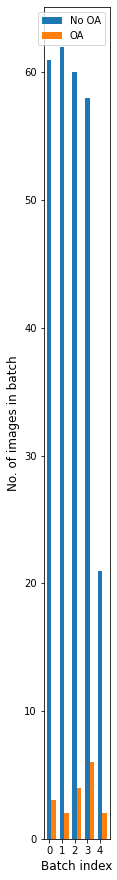

Avg Proportion of No OA per batch: 5.24
Avg Proportion of OA per batch: 0.33999999999999997
Num. unique images seen: 279/279


In [11]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

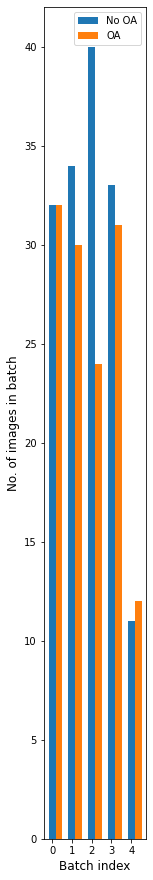

Avg Proportion of No OA per batch: 2.9999999999999996
Avg Proportion of OA per batch: 2.5799999999999996
Num. unique images seen: 133/279


In [12]:
train = CustomDataset(dataframe=train_data, transform=None)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with unnormalized inputs, no oversampling

In [ ]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 15.1538, train_acc = 86.0215, val_acc = 94.2857, train_pos = 7.8853, val_pos = 0.0000
Epoch 1, loss = 0.0000, train_acc = 93.9068, val_acc = 94.2857, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = 1.8974, train_acc = 93.5484, val_acc = 91.4286, train_pos = 1.7921, val_pos = 2.8571
Epoch 3, loss = 0.9992, train_acc = 87.0968, val_acc = 94.2857, train_pos = 10.3943, val_pos = 0.0000
Epoch 4, loss = 0.7799, train_acc = 93.1900, val_acc = 62.8571, train_pos = 2.1505, val_pos = 37.1429
Epoch 5, loss = 0.3463, train_acc = 89.6057, val_acc = 91.4286, train_pos = 5.0179, val_pos = 14.2857
Epoch 6, loss = 0.2221, train_acc = 91.3978, val_acc = 82.8571, train_pos = 2.5090, val_pos = 11.4286
Epoch 7, loss = 0.6301, train_acc = 91.3978, val_acc = 91.4286, train_pos = 4.6595, val_pos = 2.8571
Epoch 8, loss = 1.0231, train_acc = 91.0394, val_acc = 91.4286, train_pos = 6.4516, val_pos = 2.8571
Epoch 9, loss = 0.0011, train_acc = 93.9068, val_acc = 94.2857, train_pos = 5.7348, va

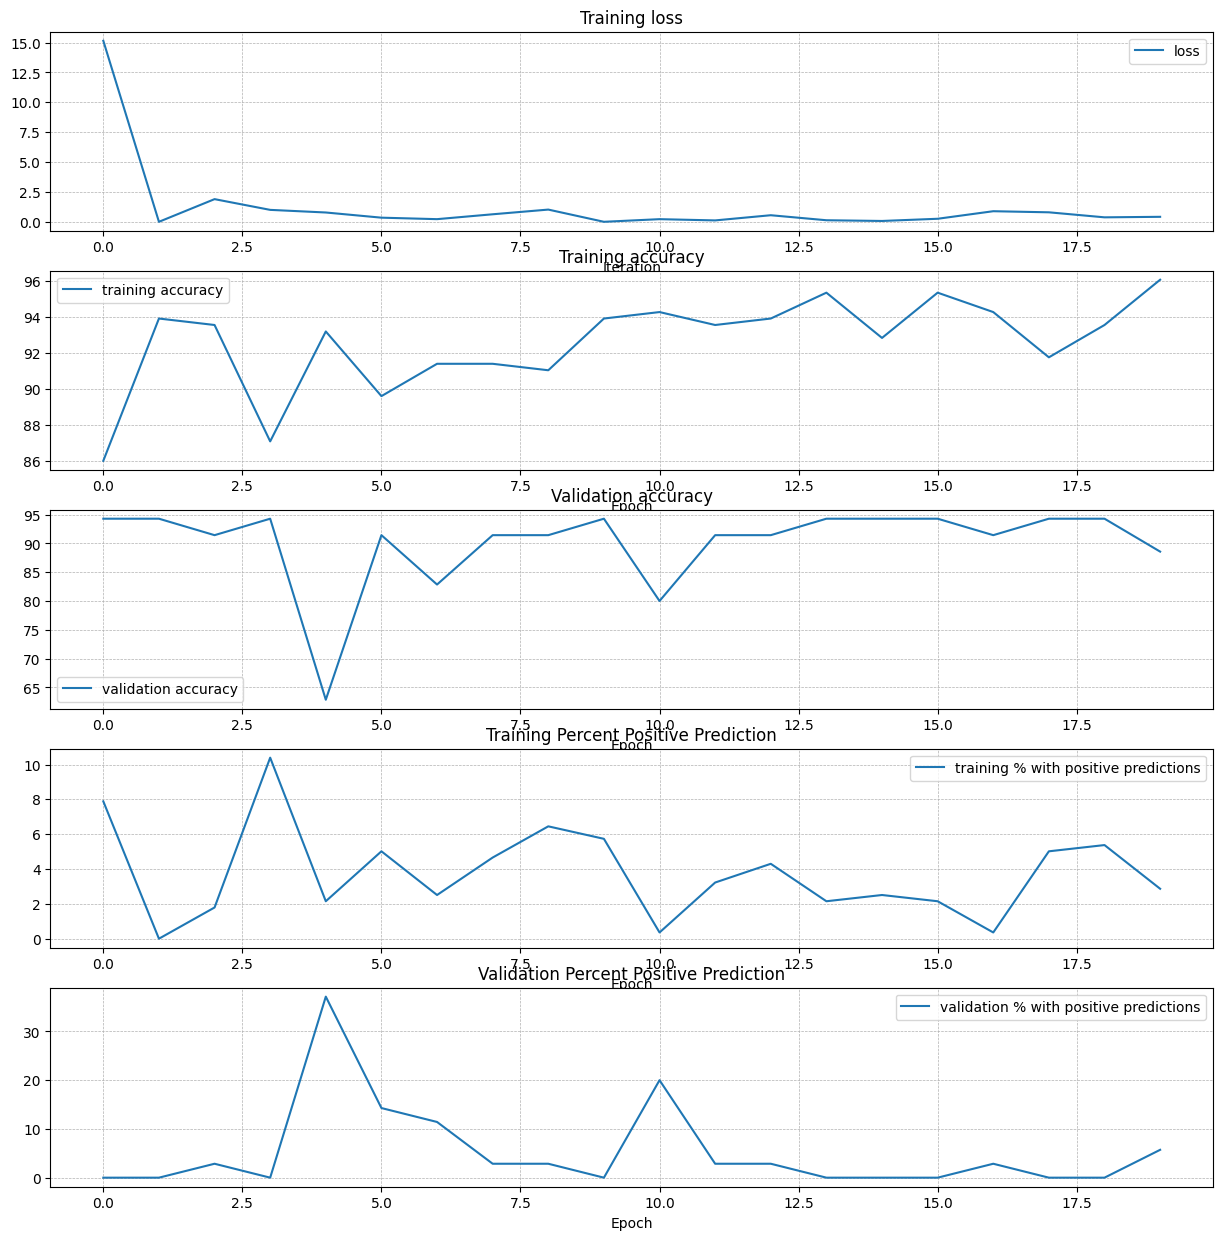

In [14]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, with oversampling

In [24]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 16.0475, train_acc = 56.6308, val_acc = 5.7143, train_pos = 40.8602, val_pos = 100.0000
Epoch 1, loss = 3.5074, train_acc = 47.3118, val_acc = 94.2857, train_pos = 68.8172, val_pos = 0.0000
Epoch 2, loss = 1.1897, train_acc = 53.7634, val_acc = 11.4286, train_pos = 19.3548, val_pos = 94.2857
Epoch 3, loss = 1.4116, train_acc = 55.9140, val_acc = 91.4286, train_pos = 69.8925, val_pos = 2.8571
Epoch 4, loss = 0.6057, train_acc = 63.7993, val_acc = 37.1429, train_pos = 20.0717, val_pos = 68.5714
Epoch 5, loss = 0.9716, train_acc = 63.7993, val_acc = 94.2857, train_pos = 59.8566, val_pos = 0.0000
Epoch 6, loss = 0.6476, train_acc = 63.4409, val_acc = 91.4286, train_pos = 50.5376, val_pos = 2.8571
Epoch 7, loss = 0.6080, train_acc = 66.3082, val_acc = 65.7143, train_pos = 18.6380, val_pos = 40.0000
Epoch 8, loss = 0.4089, train_acc = 75.9857, val_acc = 91.4286, train_pos = 42.2939, val_pos = 8.5714
Epoch 9, loss = 0.3844, train_acc = 83.1541, val_acc = 91.4286, train_pos = 3

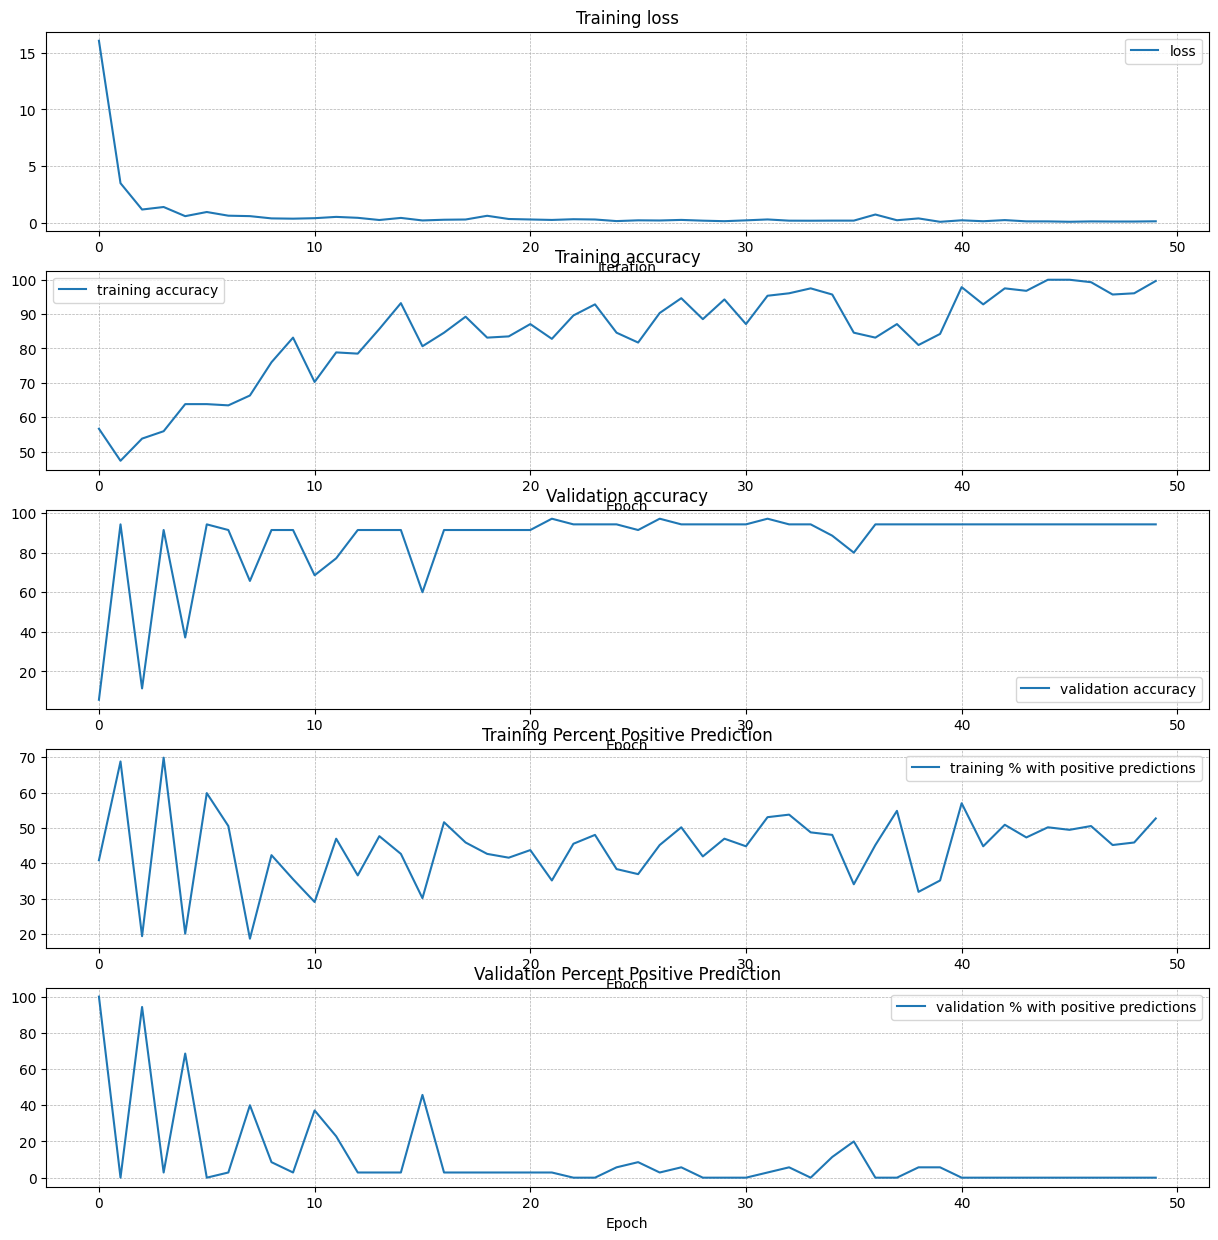

In [25]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, with weighted loss

In [16]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 160875
hidden_size = 2000
num_classes = 1
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

Epoch 0, loss = 77.2742, train_acc = 55.1971, val_acc = 94.2857, train_pos = 45.8781, val_pos = 0.0000
Epoch 1, loss = 15.8249, train_acc = 86.7384, val_acc = 5.7143, train_pos = 8.6022, val_pos = 100.0000
Epoch 2, loss = 10.3853, train_acc = 13.2616, val_acc = 91.4286, train_pos = 92.1147, val_pos = 2.8571
Epoch 3, loss = 9.5641, train_acc = 85.6631, val_acc = 91.4286, train_pos = 12.5448, val_pos = 2.8571
Epoch 4, loss = 12.0441, train_acc = 58.0645, val_acc = 5.7143, train_pos = 42.2939, val_pos = 100.0000
Epoch 5, loss = 0.7401, train_acc = 68.8172, val_acc = 14.2857, train_pos = 28.6738, val_pos = 91.4286
Epoch 6, loss = 1.7754, train_acc = 43.0108, val_acc = 94.2857, train_pos = 62.3656, val_pos = 0.0000
Epoch 7, loss = 5.4528, train_acc = 64.5161, val_acc = 54.2857, train_pos = 35.1254, val_pos = 51.4286
Epoch 8, loss = 5.0290, train_acc = 77.4194, val_acc = 65.7143, train_pos = 20.7885, val_pos = 28.5714
Epoch 9, loss = 0.5945, train_acc = 40.1434, val_acc = 94.2857, train_pos 

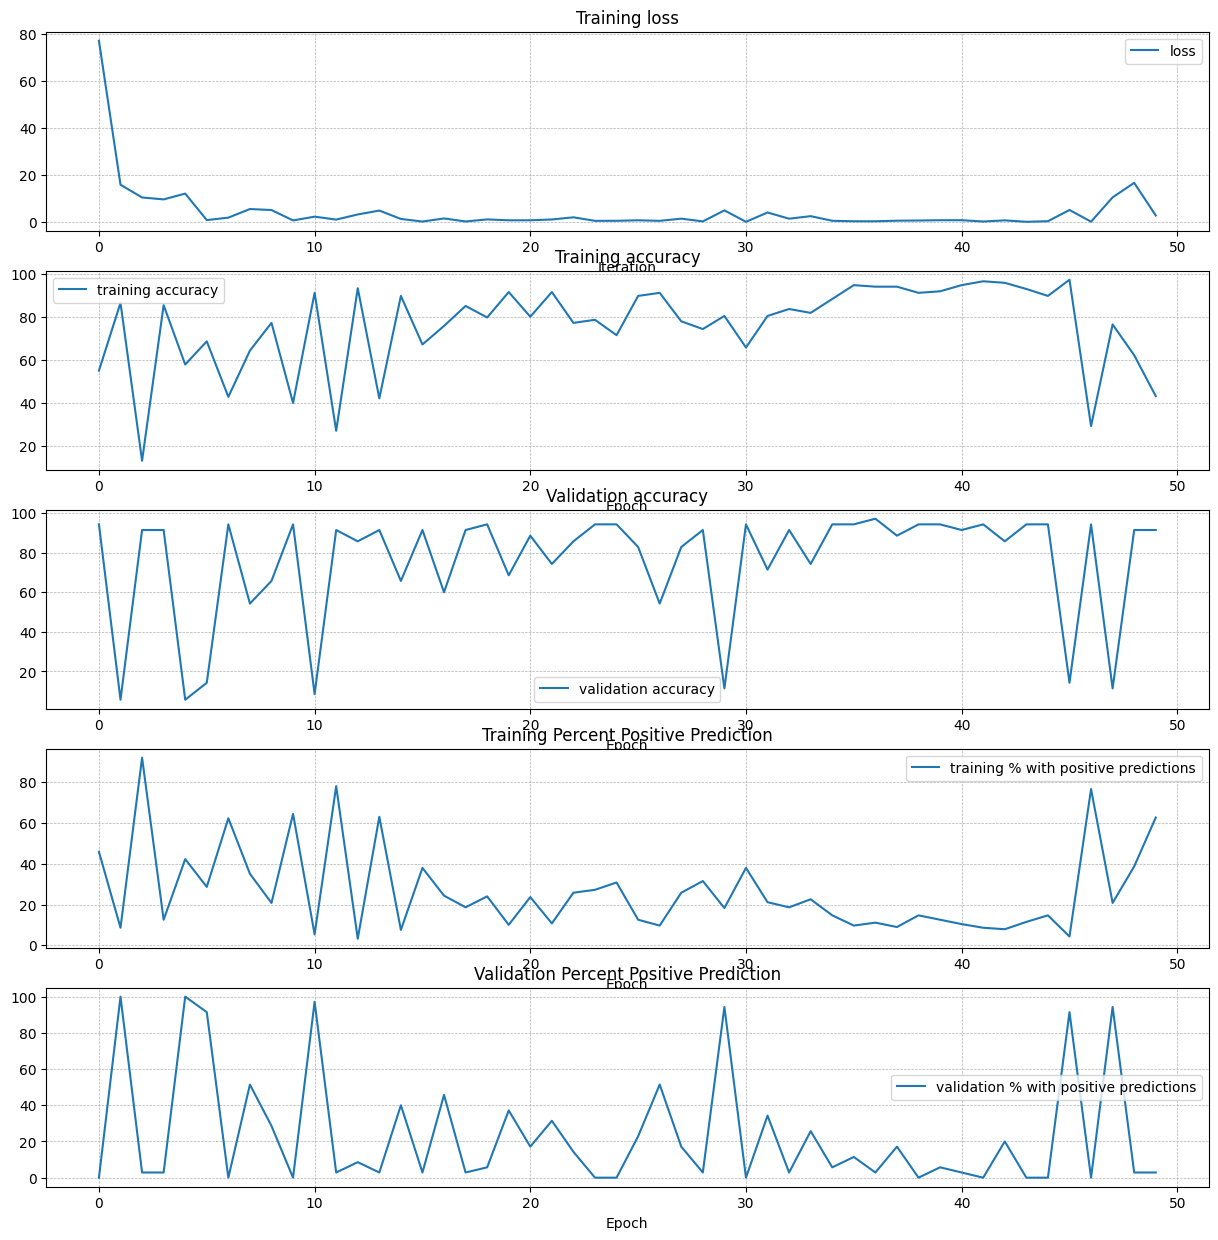

In [17]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Create Saliency Map

In [14]:
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=16, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=16, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=16)

input_size = 160875
hidden_size = 2000
num_classes = 1
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos, best_model = train_model(model, optimizer, loader_train, loader_val, epochs=5, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

RuntimeError: CUDA out of memory. Tried to allocate 1.20 GiB (GPU 0; 14.76 GiB total capacity; 1.24 GiB already allocated; 938.75 MiB free; 1.24 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
acc, percent_pos = check_accuracy(loader_val, best_model)
print(acc, percent_pos)

In [ ]:
# TODO: to be completed

def compute_saliency_maps(x, y, num_samples_pos, num_samples_neg, model):
    """
    - X: Input; Tensor of shape (N, D)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained model used to generate the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, D) giving the saliency maps for the inputs.
    """
    model.eval()
    x.requires_grad_()

    saliency = None

    scores = model(x)
    print(scores.shape)
    weight = torch.as_tensor(num_samples_neg / num_samples_pos, dtype=torch.float)
    loss = nn.BCEWithLogitsLoss(pos_weight=weight)
    loss.backward()
    saliency = x.grad.abs()
    print(saliency.shape)

    return saliency

num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes).to(device=device)
compute_saliency_maps(train_data[:-1], train_data[-1], num_samples_pos, num_samples_neg, model)